In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import hopsy

plt.rcParams["font.family"] = "serif"
#plt.rcParams['font.serif'] = ["Times"]
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['axes.linewidth'] = .2
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = .2
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = .2

dpi=300
figsize=np.array([6.4,4.8])

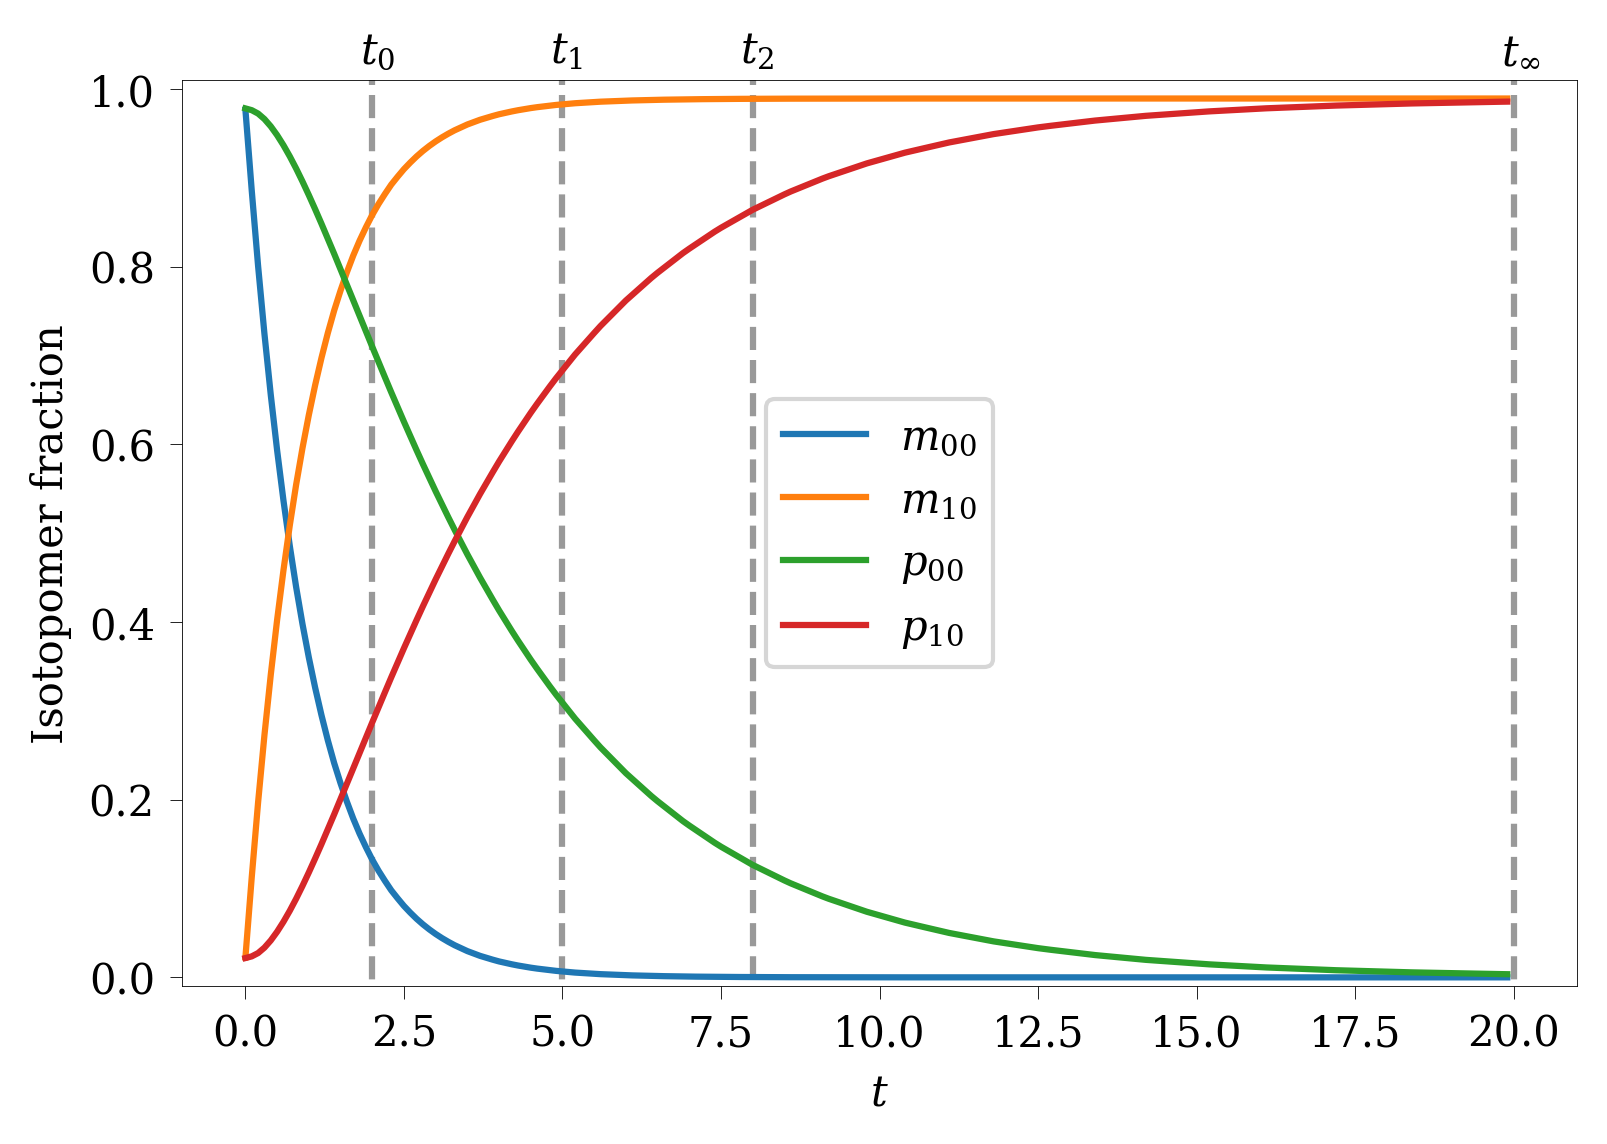

In [49]:
A, P = np.loadtxt("data/A_data", delimiter=","), np.loadtxt("data/P_data", delimiter=",")

x = A[:,0]
data = np.hstack([A[:,1:2], A[:,2:3], P[:,1:2], P[:,2:3]])

ts = [(0, 2), (1, 5), (2, 8), ("\infty", 20)]

fig, ax = plt.subplots(1, 1, dpi=dpi)

for i in range(data.shape[1]):
    ax.plot(x, data[:,i], color=cm.tab10(i))
    
for i, t in ts:
    ax.text(t-0.2, 1.03, r"$t_" + str(i) + "$")
    ax.plot([t, t], [-1, 2], color='gray', linestyle='dashed', zorder=-1, alpha=.8)
    
ax.set_ylim([-.01, 1.01])
    
ax.set_ylabel("Isotopomer fraction")
ax.set_xlabel(r"$t$")

ax.legend([r"$m_{00}$", r"$m_{10}$", r"$p_{00}$", r"$p_{10}$"])
fig.savefig("img/simplicus.svg")
plt.show()

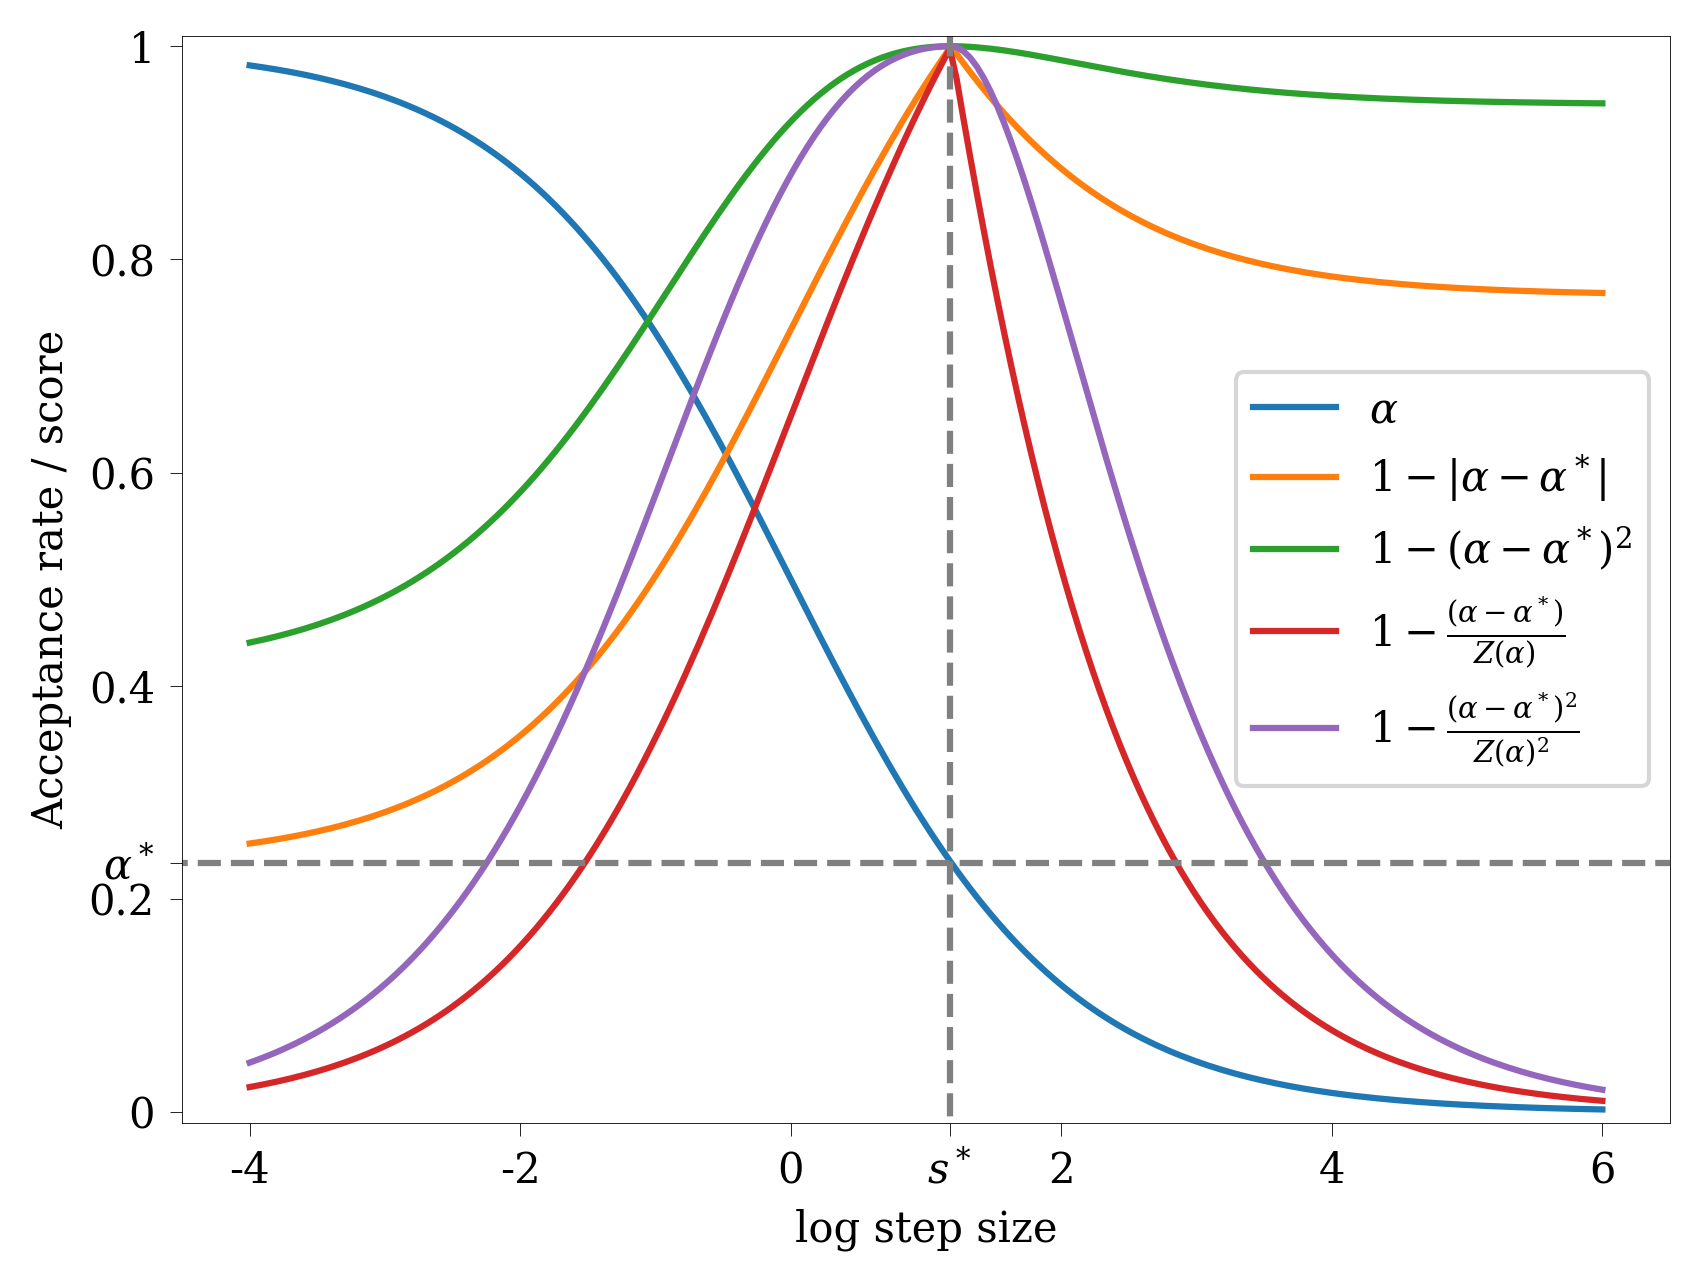

In [50]:
s = np.linspace(-4, 6, 200)
a = -1 / (1 + np.exp(-s)) + 1

target = 0.234

p1_score = lambda x: 1-np.abs(a - target)
p2_score = lambda x: 1-(a - target)**2
p1_score_norm = lambda x: 1 - (np.abs(a - target)) / ((a < 0.234) * target + (a > 0.234) * (1-target))
p2_score_norm = lambda x: 1 - ((a - target) / ((a < 0.234) * target + (a > 0.234) * (1-target)))**2

s_star = s[np.argmax(p1_score(a))]

plt.figure(dpi=dpi, figsize=figsize)

plt.plot(s, a, label=r'$\alpha$')
plt.plot(s, p1_score(a), label=r'$1 - |\alpha - \alpha^*|$')
plt.plot(s, p2_score(a), label=r'$1 - (\alpha - \alpha^*)^2$')
plt.plot(s, p1_score_norm(a), label=r'$1 - \frac{(\alpha - \alpha^*)}{Z(\alpha)}$')
plt.plot(s, p2_score_norm(a), label=r'$1 - \frac{(\alpha - \alpha^*)^2}{Z(\alpha)^2}$')

plt.plot([s_star, s_star], [-1, 2], linestyle='dashed', color='gray')
plt.plot([-10, 10], [target, target], linestyle='dashed', color='gray')

plt.xticks([-4, -2, 0, s_star, 2, 4, 6], [-4, -2, 0, r"$s^*$", 2, 4, 6])
plt.yticks([0, .2, 0.234, .4, .6, .8, 1], [0, .2, r"$\alpha^*$",.4, .6, .8, 1])

plt.xlim([-4.5, 6.5])
plt.ylim([-.01, 1.01])

plt.ylabel(r"Acceptance rate / score")
plt.xlabel(r"log step size")

plt.legend()
plt.savefig("img/scorefunctions.svg")
plt.show()

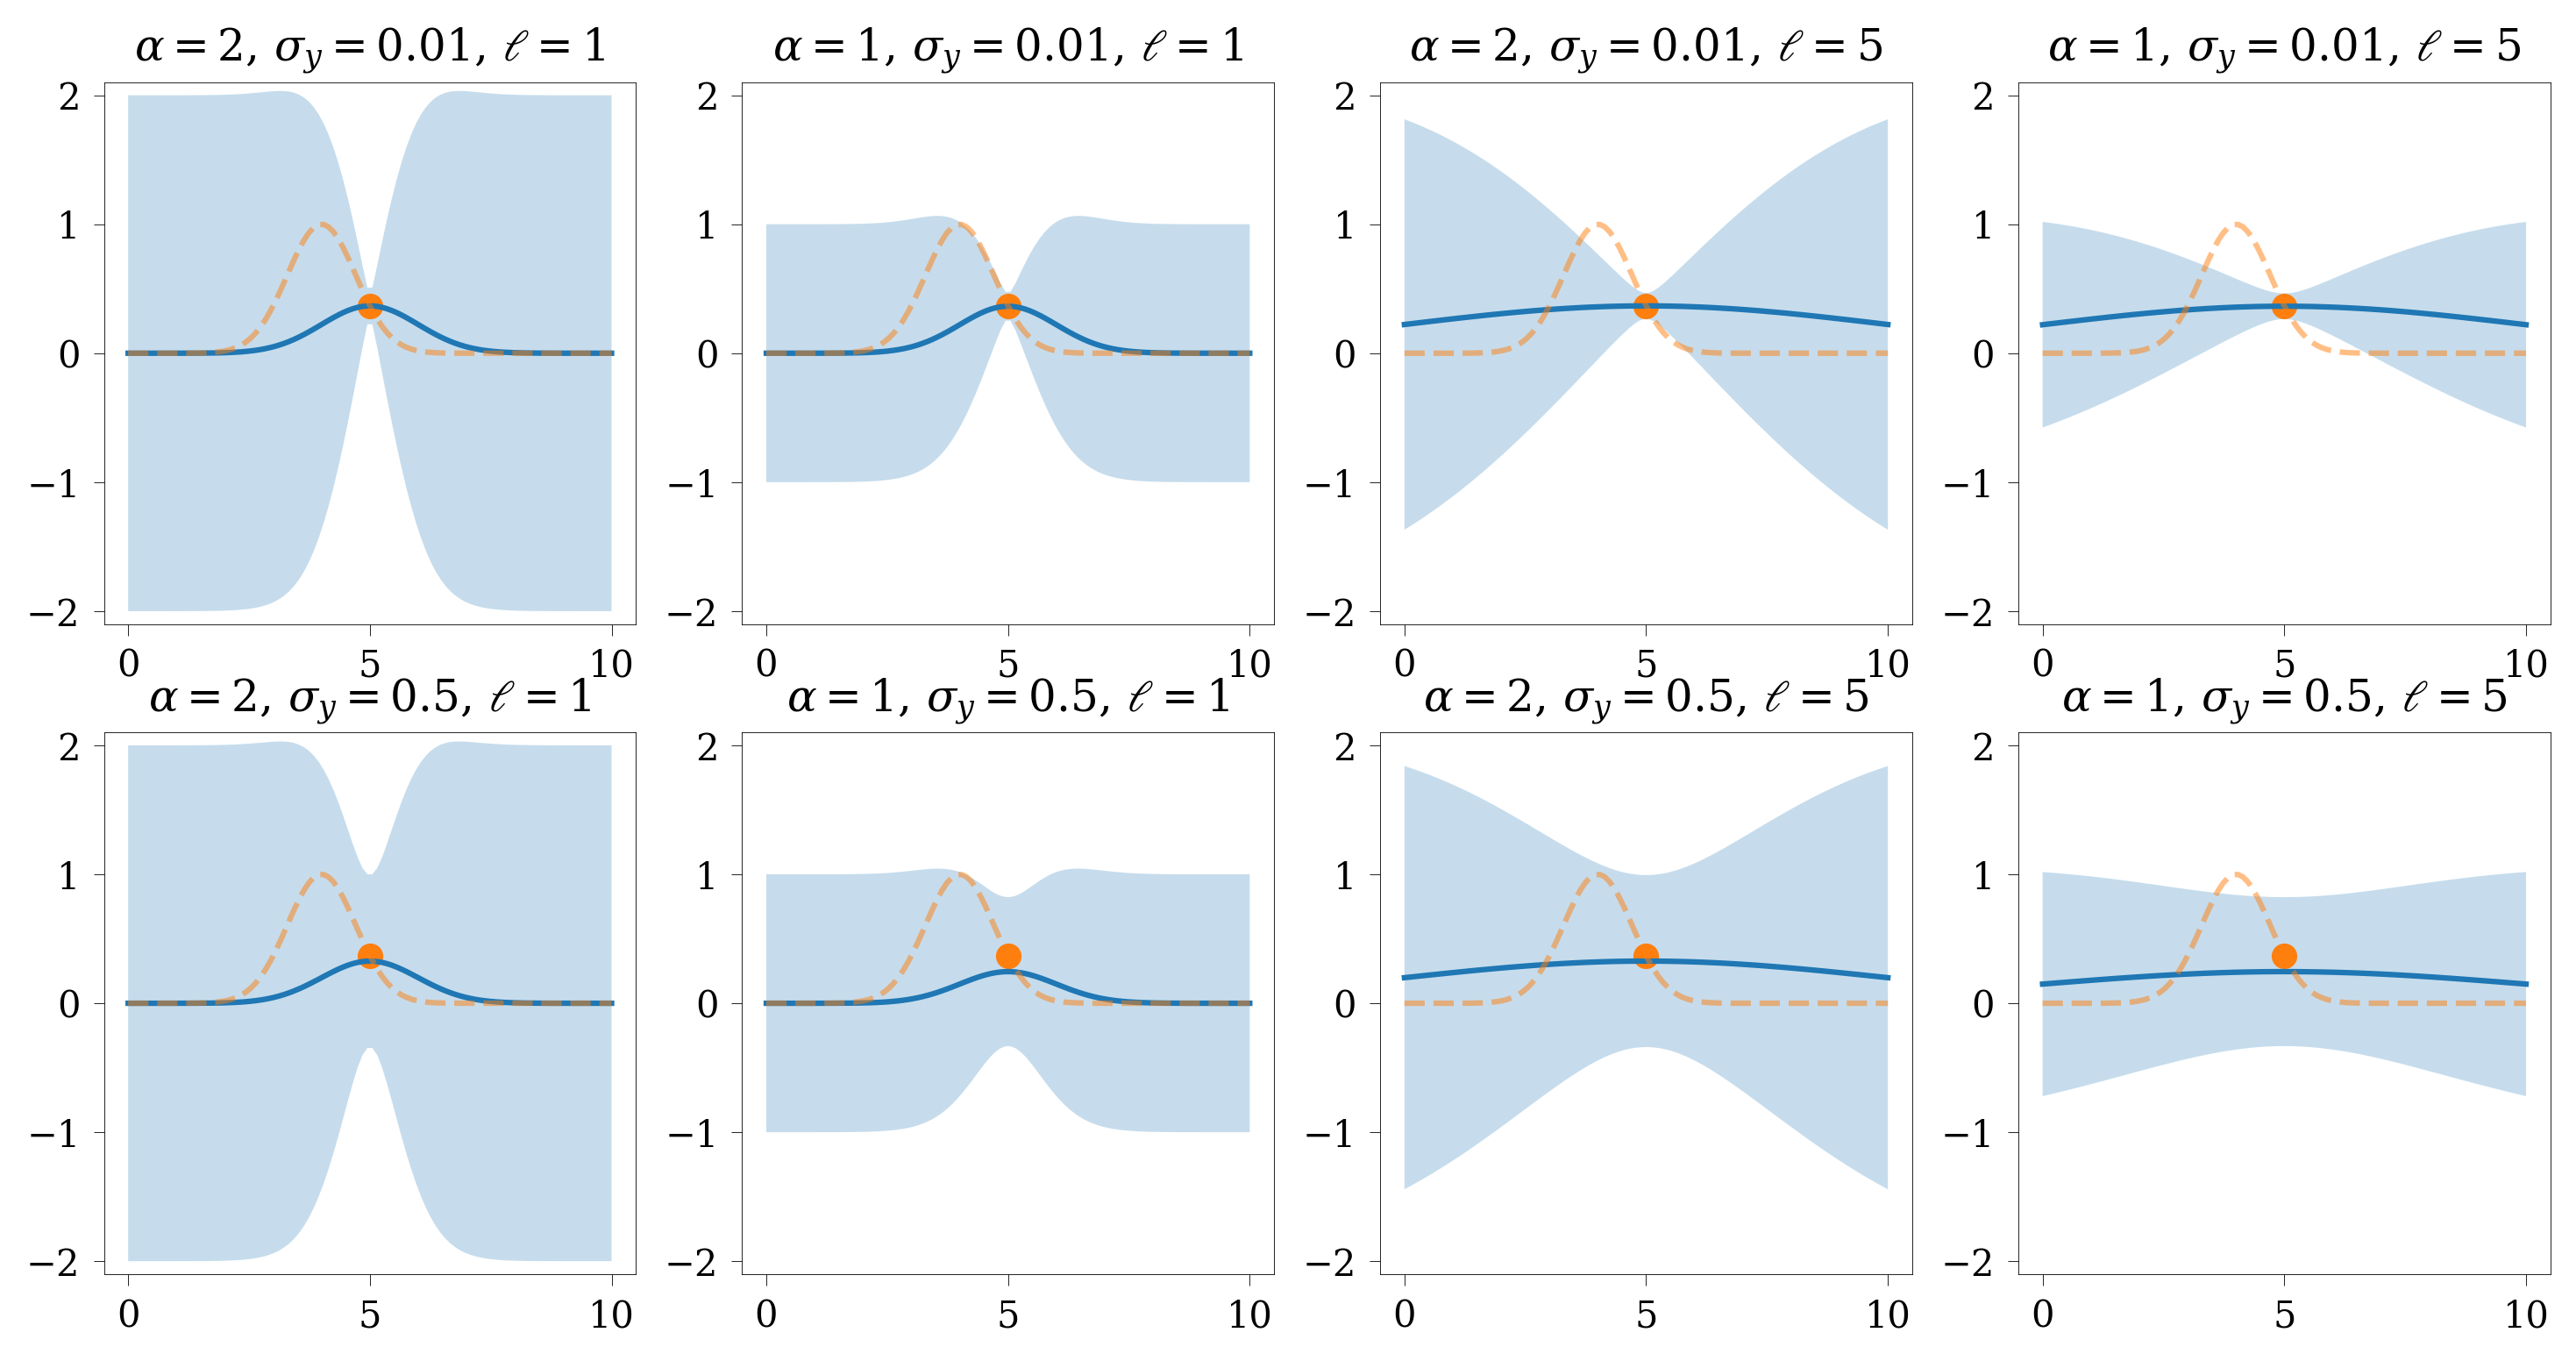

In [59]:
def kernel(x, y, l = 1, sigma = 1):
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)
    
def posterior(x, x_obs, y_obs, l = 1, sigma_f = 1, sigma_y = 0, prior_mu = 0):
    K = kernel(x_obs, x_obs, l, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = kernel(x_obs, x, l, sigma_f)
    K_ss = kernel(x, x, l, sigma_f)
    K_inv = np.linalg.inv(K)
    
    mu = prior_mu + K_s.T.dot(K_inv).dot(y_obs - prior_mu)
    cov = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu, cov

x_obs = np.array([5]).reshape(-1, 1)
y_obs = np.array([np.exp(-(x-4)**2) for x in x_obs])

X = np.linspace(0, 10, 100).reshape(-1, 1)
Y = np.array([np.exp(-(x-4)**2) for x in X])

fig, ax = plt.subplots(2, 4, dpi=dpi, figsize=(12, 6))

sigma_fs = [2, 1]
sigma_ys = [.01, .5]
lengths = [1, 5]

for i in range(ax.shape[0]):
    for j in range(int(ax.shape[1] / 2)):
        for k in range(int(ax.shape[1] / 2)):
            mu, cov = posterior(X, x_obs, y_obs, sigma_f = sigma_fs[k], sigma_y = sigma_ys[i], l=lengths[j])

            ax[i,2*j+k].set_title(
                r"$" + 
                r"\alpha = " + str(sigma_fs[k]) +
                r", \, " + 
                r"\sigma_y = " + str(sigma_ys[i]) + 
                r", \, " + 
                r"\ell = " + str(lengths[j])
                + r"$")
            ax[i,2*j+k].plot(X, mu)
            ax[i,2*j+k].fill_between(X.flatten(), 
                             (mu.T[0] - np.sqrt(np.diag(cov))).flatten(), 
                             (mu.T[0] + np.sqrt(np.diag(cov))).flatten(), alpha=0.25)

            ax[i,2*j+k].set_ylim(-2.1, 2.1)

            ax[i,2*j+k].plot(X, Y, alpha=0.5, linestyle='dashed', zorder=10)
            ax[i,2*j+k].scatter(x_obs, y_obs)
            
fig.savefig("img/sqexp.svg")
plt.show()

In [142]:
a, n = 4, 2
A, b = [[1], [-1]], [10, 5]
mixture = hopsy.Mixture([hopsy.Gaussian(mean=[a*i]) for i in range(n)])
problem = hopsy.Problem(A, b, mixture)

c = 4
mcs = [hopsy.MarkovChain(problem, hopsy.GaussianHitAndRunProposal, starting_point=[a*n / 2]) for i in range(c)]
rngs = [hopsy.RandomNumberGenerator(seed=0, stream=i) for i in range(c)]

accrate, samples = hopsy.sample(mcs, rngs, 100000, n_threads=4)

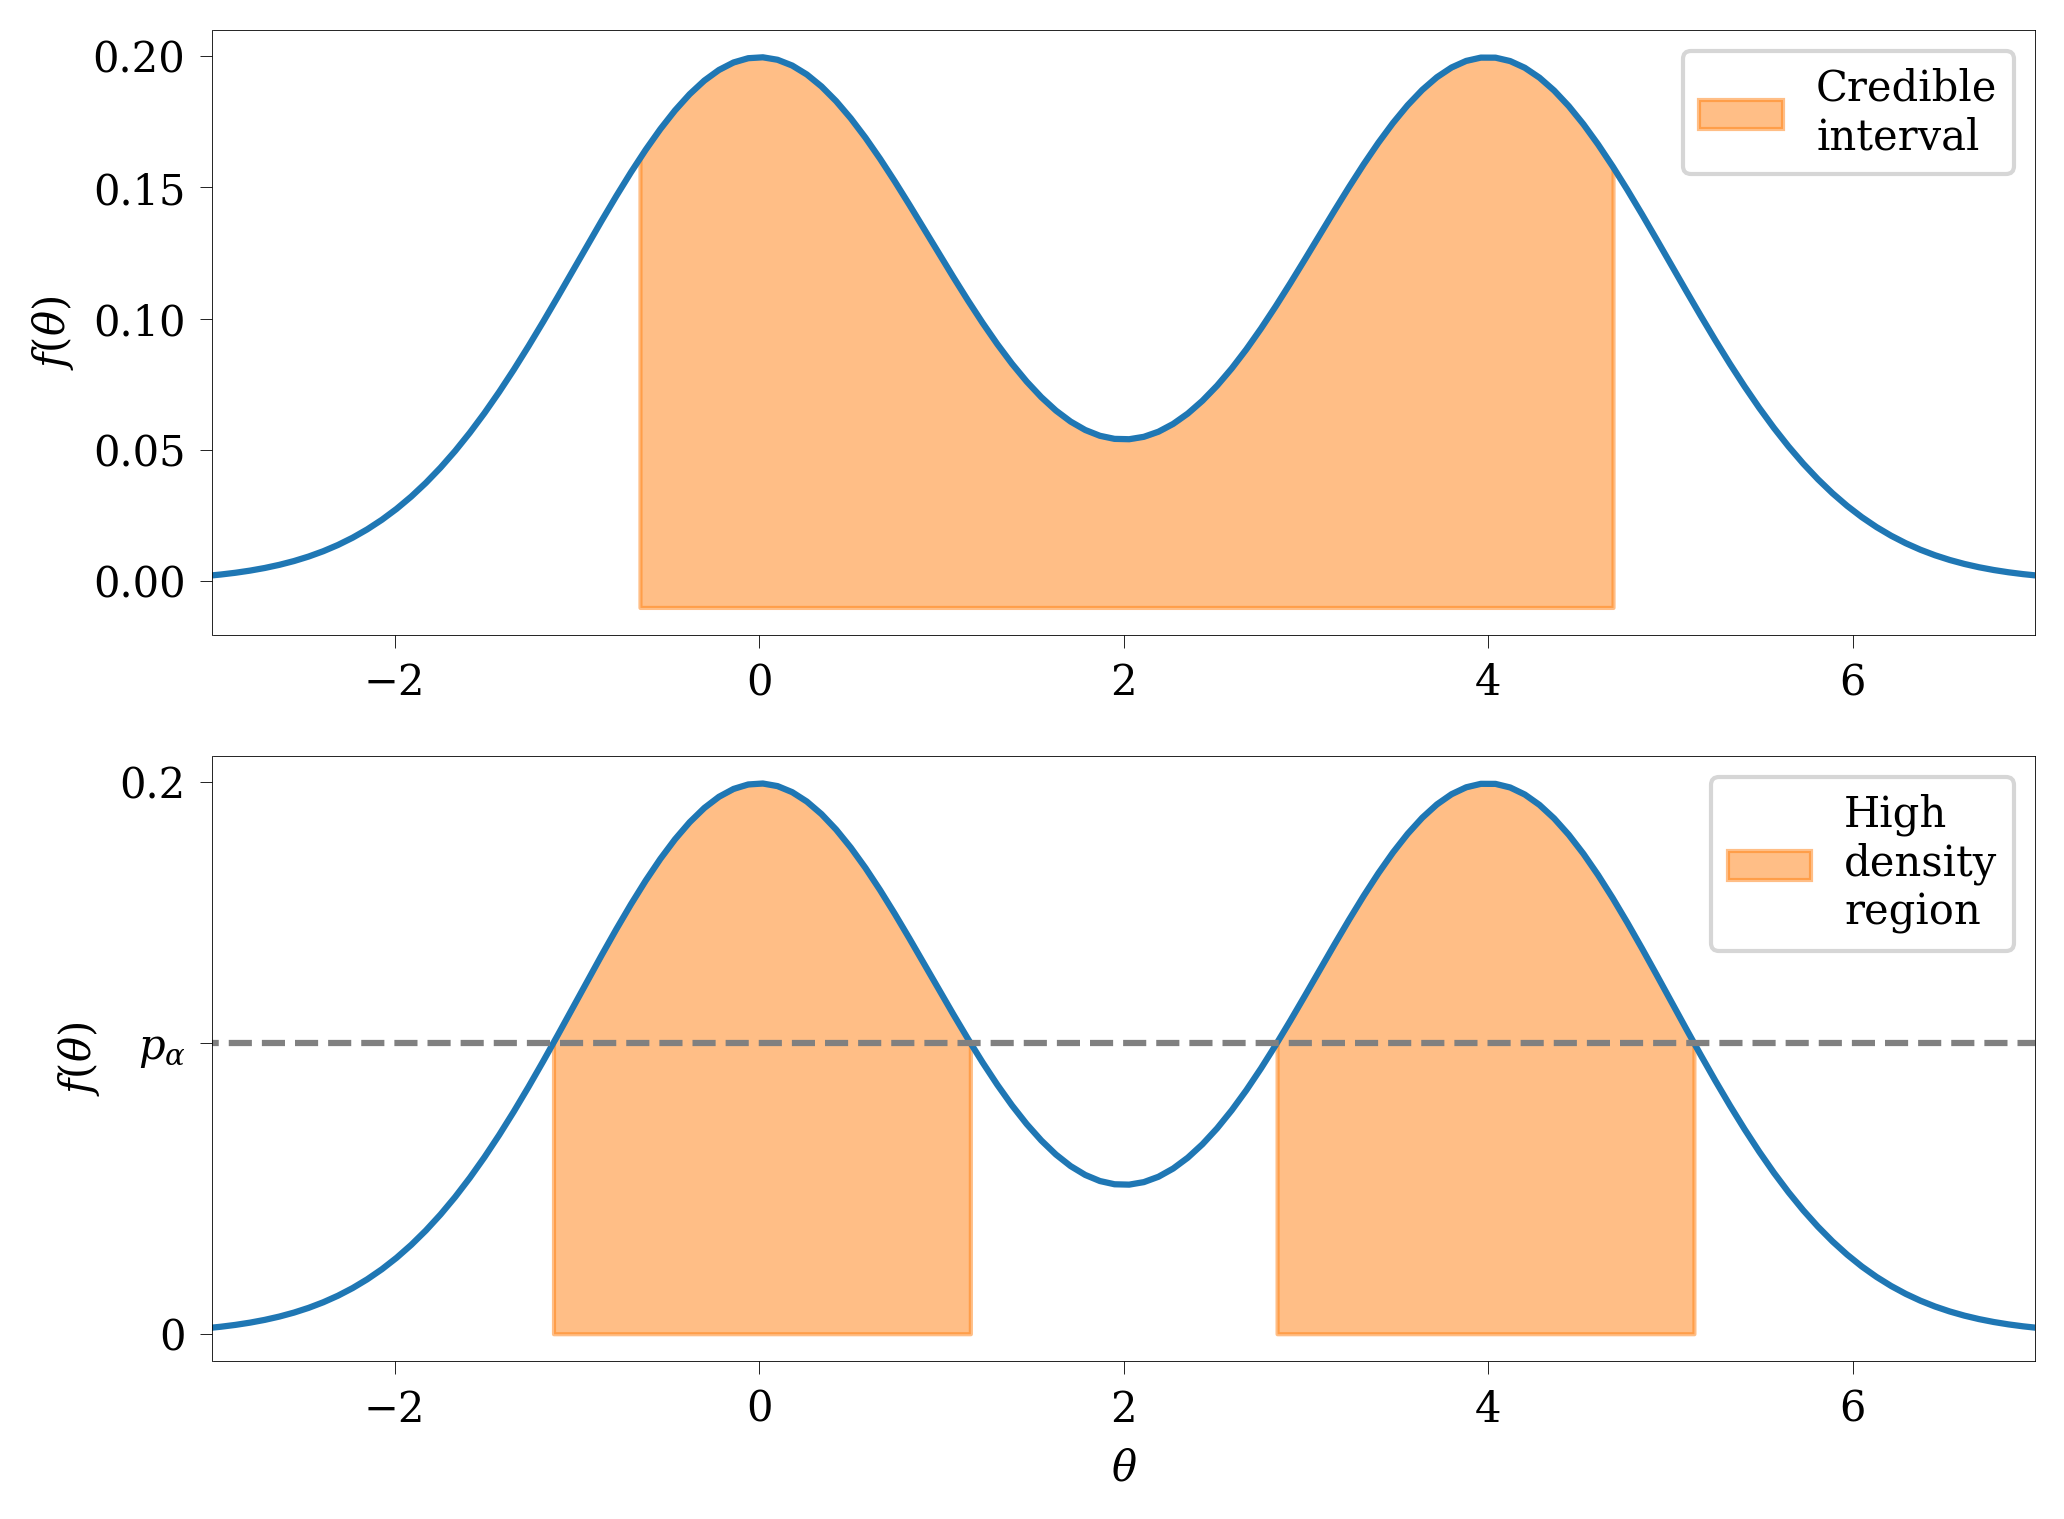

In [149]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=dpi, figsize=np.sqrt(1.5)*figsize)


a, b, N = -4, 12, 200
L = b - a
x = np.linspace(a, b, N)
density = np.array([np.exp(-mixture.compute_negative_log_likelihood([_x])) for _x in x])
ax1.plot(x, density)
ax2.plot(x, density)

alpha = 0.75
samples = samples.flatten()

## compute cris

sorted_samples = sorted(samples)
i, j = int(len(samples) * (1 - alpha) / 2), int(np.floor(len(samples) * (1 + alpha) / 2))
cri = (sorted_samples[i], sorted_samples[j])

n = int((cri[1] - cri[0]) / L * N)
_x = np.linspace(cri[0], cri[1], n)
#print(n)
_d = np.array([np.exp(-mixture.compute_negative_log_likelihood([__x])) for __x in _x])
ax1.fill_between(_x, _d * 0 - .01, _d, color='C1', alpha=.5, label='Credible\ninterval')


ax1.set_xlim([-3, 7])

ax1.set_ylabel(r"$f(\theta)$")
#ax1.set_xlabel(r"$\theta$")

    
## compute hdis
nlls = [np.exp(-mixture.compute_negative_log_likelihood([_x])) for _x in samples]
sorted_nlls = sorted(nlls)
p_alpha = sorted_nlls[int((1-alpha) * len(samples))]

is_hdi_sample = (nlls > p_alpha)

foo = np.array([samples, is_hdi_sample]).T
foo = foo[foo[:, 0].argsort()]

samples = foo[:,0]
is_hdi_sample = foo[:,1]

hdis = []
last_start = None
for i in range(len(samples)):
    if is_hdi_sample[i] and last_start is None:
        last_start = samples[i]
    if not is_hdi_sample[i] and last_start is not None:
        hdis.append((last_start, samples[i-1]))
        last_start = None
        


# hdi level
ax2.plot([a, b], [p_alpha, p_alpha], linestyle='dashed', color='gray')
    
# hdis
first = True
for hdi in hdis:
    n = int((hdi[1] - hdi[0]) / L * N)
    _x = np.linspace(hdi[0], hdi[1], n)
    #print(n)
    _d = np.array([np.exp(-mixture.compute_negative_log_likelihood([__x])) for __x in _x])
    if first:
        ax2.fill_between(_x, _d * 0, _d, color='C1', alpha=.5, label="High\ndensity\nregion")
        first =False
    else:
        ax2.fill_between(_x, _d * 0, _d, color='C1', alpha=.5)

ax2.set_xlim([-3, 7])

ax2.set_yticks([0, p_alpha, 0.2])
ax2.set_yticklabels([0, r"$p_{\alpha}$", 0.2])

ax2.set_ylabel(r"$f(\theta)$")
ax2.set_xlabel(r"$\theta$")
    
ax1.legend()
ax2.legend()
fig.savefig("img/cri-hdi.svg")
plt.show()